In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

In [2]:
# ----------------------------------------
# Step 1: Load and Preprocess the Training Data
# ----------------------------------------

# Load the data
train_data = pd.read_csv('train_data.csv', parse_dates=['date'], index_col='date')

# Apply EWMA and Rolling Mean to each feature
for feature in ['open', 'high', 'low', 'Volume BTC', 'Volume USD']:
    train_data[f'{feature}_EWMA'] = train_data[feature].ewm(span=20, adjust=False).mean()  # EWMA for each feature
    train_data[f'{feature}_Rolling_Mean'] = train_data[feature].rolling(window=20).mean()  # Rolling Mean for each feature

# Drop rows with NaN values (due to rolling mean and EWMA calculations)
train_data.dropna(inplace=True)

# Define the features and target
X_train = train_data[['open_EWMA', 'high_EWMA', 'low_EWMA', 'Volume BTC_EWMA', 'Volume USD_EWMA',
                      'open_Rolling_Mean', 'high_Rolling_Mean', 'low_Rolling_Mean', 'Volume BTC_Rolling_Mean', 'Volume USD_Rolling_Mean']]
y_train = train_data['close']

# Build and train the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)


LinearRegression()

In [3]:
# ----------------------------------------
# Step 2: Load and Preprocess the Test Data
# ----------------------------------------

# Load the test data
test_data = pd.read_csv('test_data.csv', parse_dates=['date'], index_col='date')

# Apply EWMA and Rolling Mean to each feature for the test data
for feature in ['open', 'high', 'low', 'Volume BTC', 'Volume USD']:
    test_data[f'{feature}_EWMA'] = test_data[feature].ewm(span=20, adjust=False).mean()  # EWMA for each feature
    test_data[f'{feature}_Rolling_Mean'] = test_data[feature].rolling(window=20).mean()  # Rolling Mean for each feature

# Drop rows with NaN values (due to rolling mean and EWMA calculations)
test_data.dropna(inplace=True)

# Define the test features
X_test = test_data[['open_EWMA', 'high_EWMA', 'low_EWMA', 'Volume BTC_EWMA', 'Volume USD_EWMA',
                    'open_Rolling_Mean', 'high_Rolling_Mean', 'low_Rolling_Mean', 'Volume BTC_Rolling_Mean', 'Volume USD_Rolling_Mean']]

# Make Predictions on Test Data
predicted_close_prices = model.predict(X_test)

# Add predictions to test data
test_data['Predicted_Close'] = np.nan
test_data.iloc[-len(predicted_close_prices):, test_data.columns.get_loc('Predicted_Close')] = predicted_close_prices


In [4]:
# ----------------------------------------
# Step 3: Model Evaluation Metrics and Visualization
# ----------------------------------------

# Define the percentage accuracy function
def percentage_accuracy(y_true, y_pred, threshold=0.05):
    percentage_error = np.abs((y_true - y_pred) / y_true)  # Calculate percentage error
    return np.mean(percentage_error < threshold) * 100  # Percentage of predictions within threshold

# Align data for MSE calculation
aligned_test_data = test_data[['close', 'Predicted_Close']].dropna()
mse = mean_squared_error(aligned_test_data['close'], aligned_test_data['Predicted_Close'])
mae = mean_absolute_error(aligned_test_data['close'], aligned_test_data['Predicted_Close'])
r2 = r2_score(aligned_test_data['close'], aligned_test_data['Predicted_Close'])
accuracy = percentage_accuracy(aligned_test_data['close'], aligned_test_data['Predicted_Close'], threshold=0.05)  # 5% threshold
# Print the results
print(f"Mean Squared Error (MSE) on Test Data: {mse}")
print(f"Mean Absolute Error (MAE) on Test Data: {mae}")
print(f"R-squared (R²) on Test Data: {r2}")
print(f"Percentage Accuracy on Test Data (within 5%): {accuracy}%")


Mean Squared Error (MSE) on Test Data: 4341.265332081664
Mean Absolute Error (MAE) on Test Data: 44.65970277994226
R-squared (R²) on Test Data: 0.9999479256516662
Percentage Accuracy on Test Data (within 5%): 99.9997660971913%


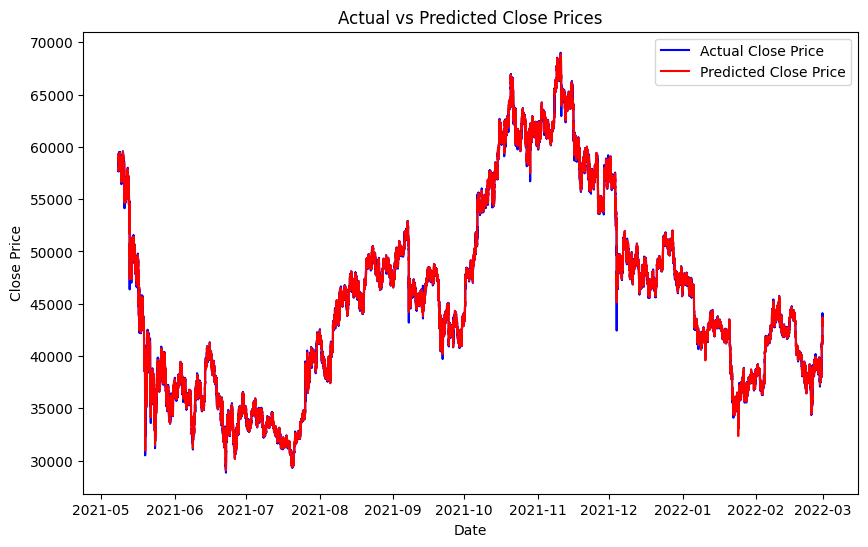

In [5]:
# Visualize the Predictions
plt.figure(figsize=(10, 6))
plt.plot(aligned_test_data['close'], label='Actual Close Price', color='blue')
plt.plot(aligned_test_data['Predicted_Close'], label='Predicted Close Price', color='red')
plt.title('Actual vs Predicted Close Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()